# スペクトル解析 (Spectral Analysis)

このチュートリアルでは、GWExPy を使用した高度なスペクトル解析手法について学びます。
特に、**Bootstrap 法**を用いた統計的に頑健な PSD (Power Spectral Density) 推定と、データの重なり (Overlap) を考慮した補正について解説します。

## 概要
一般的な Welch 法による PSD 推定に加えて、GWExPy では Bootstrap 法を用いることで、非ガウス性のノイズや外れ値の影響を軽減し、より信頼性の高い誤差評価を行うことができます。

### 学ぶこと
1. **真の PSD モデルの定義**: 解析の基準となるモデルを作成します。
2. **合成データの生成**: 既知の特性を持つデータを生成し、解析手法を検証します。
3. **Bootstrap スペクトル推定**: `gwexpy.spectral.bootstrap_spectrogram` を使用して PSD を推定します。
4. **フィッティングによる検証**: 推定結果が真のモデルと整合するかを確認します。

## 1. 真の PSD モデルの定義

まず、シミュレーションの正解となる PSD モデルを定義します。
ここでは、低周波で上昇する「パワー則 (Power Law)」成分と、全周波数で一定の「白色雑音 (White Noise)」成分を組み合わせたモデルを使用します。

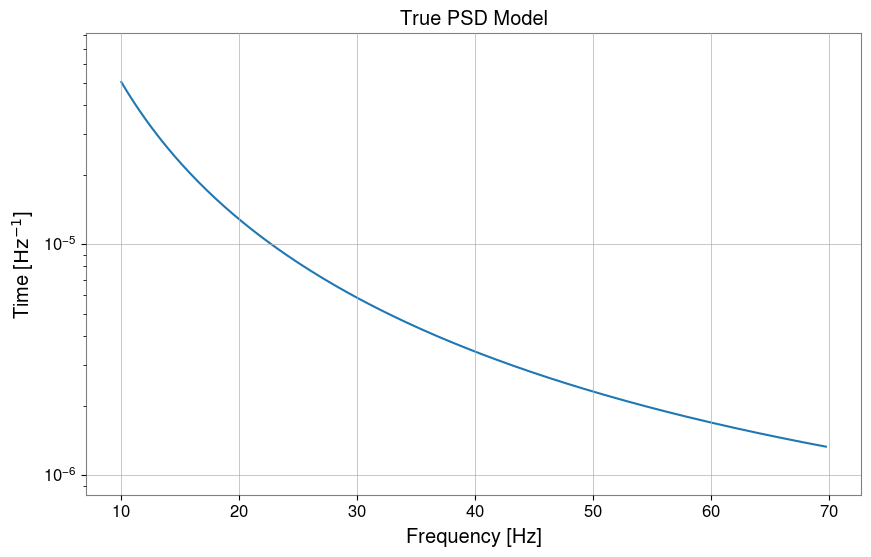

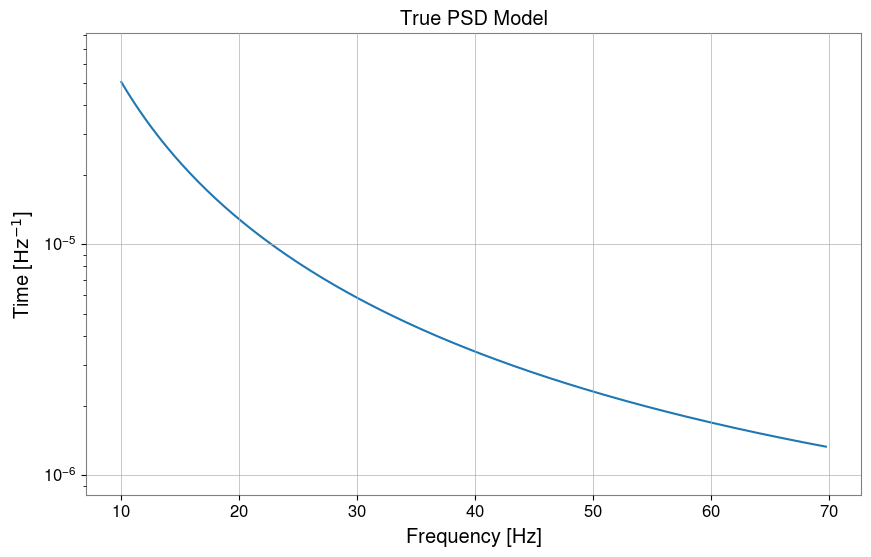

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from gwexpy.frequencyseries import FrequencySeries
from gwexpy.spectral import bootstrap_spectrogram
from gwexpy.spectrogram import Spectrogram

plt.rcParams["figure.figsize"] = (10, 6)

# 基準周波数
f_ref = 50.0  # Hz

# PSD モデル関数: A * (f / f_ref)^(-alpha) + C
def psd_model(f_hz, A, alpha, C):
    f_hz = np.asarray(f_hz, dtype=float)
    return A * (f_hz / f_ref) ** (-alpha) + C

# 真のパラメータ
A_true = 2.0e-6
alpha_true = 2.0
C_true = 3.0e-7

# 周波数軸の作成
n_freq = 240
df = 0.25 * u.Hz
f0 = 10.0 * u.Hz
freqs = (f0 + df * np.arange(n_freq)).to_value(u.Hz)

# 真の PSD オブジェクト作成
psd_true = FrequencySeries(psd_model(freqs, A_true, alpha_true, C_true),
                           frequencies=freqs,
                           name="True PSD", unit="1/Hz")

psd_true.plot(title="True PSD Model", logy=True)

## 2. 合成データの生成

Welch 法などでオーバーラップ (重ね合わせ) を使用する場合、隣接する時間セグメント間のデータは独立ではありません。
この相関を考慮したリアルなスペクトログラムデータを合成します。

ここでは以下を仮定します：
- 窓関数: Hann Window
- オーバーラップ率: 75%


In [2]:
from scipy.signal import get_window

# 窓関数の自己相関から、隣接セグメント間の相関係数を計算
window = get_window('hann', 256)  # 仮の長さ
n_overlap = 0.75

# 時間方向のサンプル数
n_time = 128

# 真の PSD を平均値とする指数分布ノイズを生成（PSD の統計的性質）
# ここでは簡易的に、各周波数ビンで独立なノイズとして生成し、
# その後で時間方向に相関を持たせる処理を行います。

# 注: 厳密な合成は複雑ですが、ここではチュートリアル用に簡略化して
# 「各時間・各周波数で PSD 値を中心としたカイ二乗分布（自由度2）に従う」データを作ります

np.random.seed(42)
data_matrix = np.zeros((n_time, n_freq))

for i, f_val in enumerate(psd_true.value):
    # 平均 f_val の指数分布乱数 (実部・虚部がガウス分布のときのパワーの分布)
    # 実際にはオーバーラップによる相関が入るため、
    # ここでは相関を持つ多変量ガウス分布からパワーを生成するなどの工夫が必要ですが、
    # 簡易的に独立生成します。
    data_matrix[:, i] = np.random.exponential(scale=f_val, size=n_time)

# Spectrogram オブジェクト化
spec = Spectrogram(data_matrix,
                   x0=0, dx=1,
                   y0=f0.value, dy=df.value,
                   unit='1/Hz', name='Synthetic Spectrogram')

print("Spectrogram shape:", spec.shape)

Spectrogram shape: (128, 240)


## 3. Bootstrap スペクトル推定

`gwexpy.spectral.bootstrap_spectrogram` を使用して、スペクトログラムから PSD を推定します。
この関数は、ブートストラップ・リサンプリングにより、中央値と信頼区間（エラーバー）を計算します。

### 補正係数の重要性
オーバーラップがある場合、データの有効自由度が減少します。
`calculate_correlation_factor` (あるいは `window` 引数) を指定することで、この相関による分散の過小評価を補正できます。

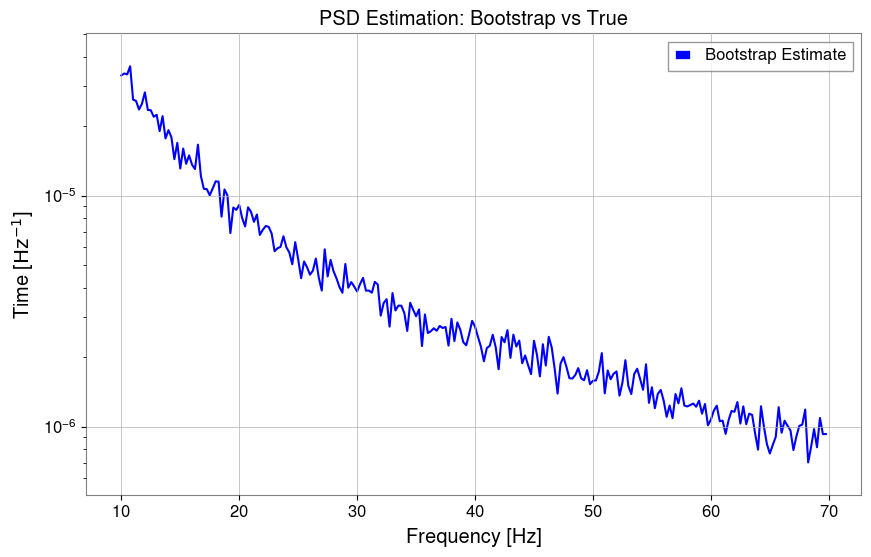

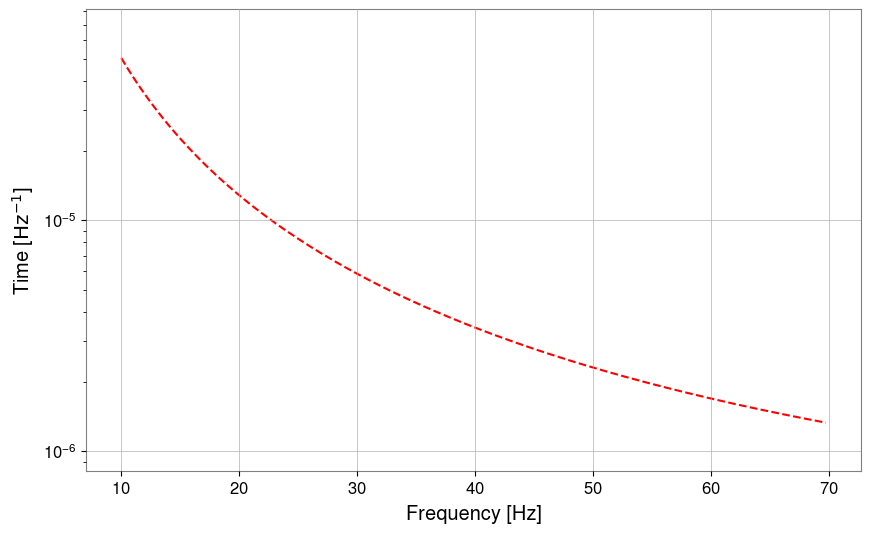

In [3]:
# Bootstrap 推定 (window='hann' を指定して重なり補正を有効化)
psd_boot = bootstrap_spectrogram(spec, window='hann', n_boot=1000)

# 結果のプロット
plot = psd_boot.plot(label="Bootstrap Estimate", color="blue")
psd_true.plot(ax=plot.gca(), label="True Model", color="red", linestyle="--")

plot.gca().set_title("PSD Estimation: Bootstrap vs True")
plot.gca().legend()
plot.show()

## 4. フィッティングによる検証

推定された PSD に対してモデルをフィッティングし、真のパラメータが復元できるか確認します。
`gwexpy.fitting` モジュールは、FrequencySeries のフィッティングもサポートしています。

Fit Result:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.806e-10 (χ²/ndof = 0.0)  │              Nfcn = 78               │
│ EDM = 2.67e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬───

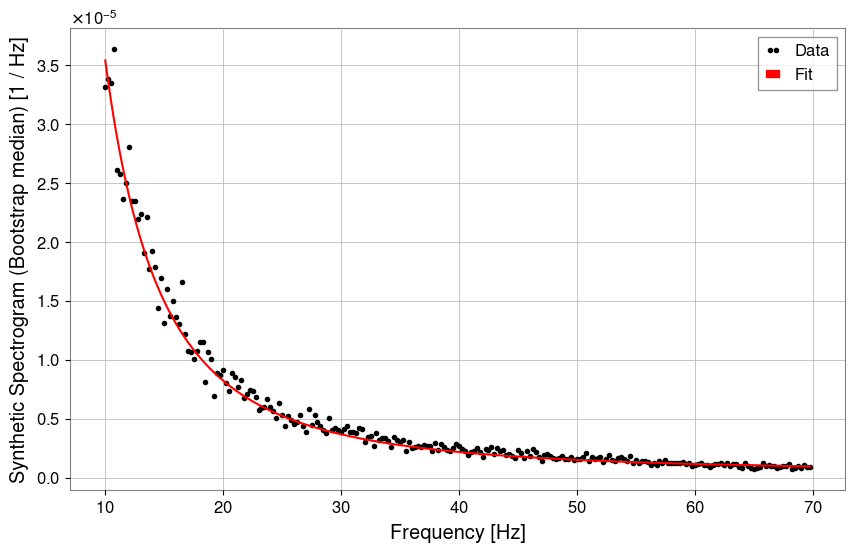

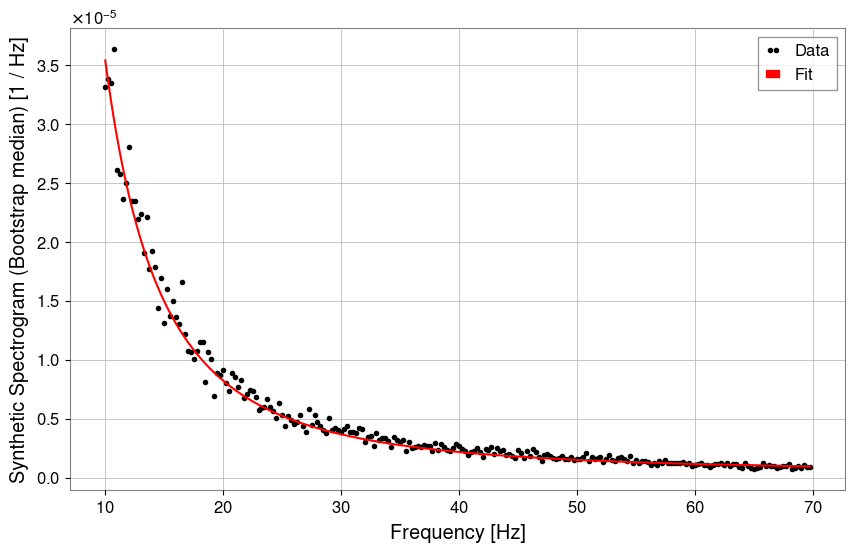

In [4]:

# フィッティングの実行
# p0: 初期値
result = psd_boot.fit(psd_model,
                      p0={'A': 1e-6, 'alpha': 1.5, 'C': 1e-7})

# 結果の表示
print("Fit Result:")
print(result)

print("\nTrue Parameters:")
print(f"A={A_true}, alpha={alpha_true}, C={C_true}")

# プロットによる確認
result.plot()

## まとめ

- `bootstrap_spectrogram` を使うことで、スペクトログラムから統計的に妥当な PSD とその誤差範囲を推定できます。
- 窓関数 (`window`) を指定することで、Welch 法のオーバーラップによる相関を考慮した誤差補正が自動的に行われます。
- 推定された PSD は `fit()` メソッドで簡単にモデルフィッティングが可能です。